In [2]:
!pip install tensorflow

You should consider upgrading via the 'c:\users\misha\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.



Using legacy 'setup.py install' for termcolor, since package 'wheel' is not installed.
Using legacy 'setup.py install' for wrapt, since package 'wheel' is not installed.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.2
    Uninstalling numpy-1.20.2:
      Successfully uninstalled numpy-1.20.2
    Running setup.py install for termcolor: started
    Running setup.py install for termcolor: finished with status 'done'
    Running setup.py install for wrapt: started
    Running setup.py install for wrapt: finished with status 'done'


In [4]:
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=1bf0b4ffb01f31e1ee10156b29bba56bd37b8f19f2a7c73e0840c3f94a461c10
  Stored in directory: c:\users\misha\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


You should consider upgrading via the 'c:\users\misha\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [6]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=ed970633811bd17dd49f25210f7120c0777e2f752f0fe1f845a6ae93f4ed076d
  Stored in directory: c:\users\misha\appdata\local\pip\cache\wheels\4b\a5\2d\4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils


You should consider upgrading via the 'c:\users\misha\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [10]:
!pip install opencv-python

You should consider upgrading via the 'c:\users\misha\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [30]:
!pip install pandas

You should consider upgrading via the 'c:\users\misha\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [29]:
!pip install seaborn

You should consider upgrading via the 'c:\users\misha\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
!nvidia-smi

Wed Apr 21 14:13:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.40       Driver Version: 461.40       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8    N/A /  N/A |    169MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
os.environ['CUDA_VISIBLE_DEVISE']='3' # для запуска на CPU '-1'

In [18]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # инициализируем модель вместе с входной формой как
        # "каналы последние" и сам размер каналов
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
       # если мы используем "сначала каналы", обновим форму ввода и размер каналов
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
            #Добавляем слои
            # CONV => RELU => POOL
            #Размер фильтра 32
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu")) #функция активации с последующей пакетной нормализацией.
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))
        
        #добавим ( CONV = > RELU ) * 2  слоев 
        #Размер фильтра 64
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        #Несколько слоёв CONV и Relu вместе позволяет нам изучить более богатый набор функций
        
        
        #Добавим ещё один набор
        # (CONV => RELU) * 2 => POOL
        # Увеличим размер фильтра до 128
        # Выпадение 25% узлов выполняется, чтобы снова уменьшить переобучение
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        
         # первый (и единственный) набор слоев FC => RELU
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax классификатор
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        # return the constructed network architecture
        return model

In [19]:
# инициализировать количество эпох для тренировки, начальную скорость обучения,
# размер пакета и размеры изображения
EPOCHS = 100
INIT_LR = 1e-3 #начальнаня скорость обучения
BS = 32 #контролирует размер пакетов передаваемых на обучение
IMAGE_DIMS = (256, 256, 3) # размеры изображения и 3х канальный RGB

# инициализируем данные и метки
data = []
labels = []

# захватываем пути изображения и случайным образом перемешиваем их
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images("Flowers")))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [20]:
#Перебираем изображения 
for imagePath in imagePaths:
    
    # загружаем изображение, предварительно обработать его и сохранив в списке данных
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image) #  преобразования изображения в массив, совместимый с Keras
    data.append(image)
    
    # извлекаем метку класса из пути к изображению и обновляем
    # список ярлыков
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [21]:
# масштабировать яркость необработанных пикселей в диапазоне [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

# Считывание меток
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

#разделить данные на обучение и тестирование, используя 80%
# данные для обучения и оставшиеся 20% для тестирования
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

[INFO] data matrix: 1436.16MB


In [22]:
#объект увеличения данных изображения

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [26]:
# Инициализруем модель
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2], classes=len(lb.classes_))

opt = RMSprop(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


# Обучение 

In [27]:
# Обучаем
print("[INFO] training network...")
H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/100
23/23 [==============================] - 64s 3s/step - loss: 4.4314 - accuracy: 0.1110 - val_loss: 4.0040 - val_accuracy: 0.0374
Epoch 2/100
23/23 [==============================] - 59s 3s/step - loss: 3.6121 - accuracy: 0.1727 - val_loss: 3.8464 - val_accuracy: 0.0374
Epoch 3/100
23/23 [==============================] - 59s 3s/step - loss: 3.4186 - accuracy: 0.1926 - val_loss: 5.0133 - val_accuracy: 0.0214
Epoch 4/100
23/23 [==============================] - 59s 3s/step - loss: 3.0450 - accuracy: 0.2347 - val_loss: 6.1517 - val_accuracy: 0.0428
Epoch 5/100
23/23 [==============================] - 60s 3s/step - loss: 2.7305 - accuracy: 0.3199 - val_loss: 6.0596 - val_accuracy: 0.0214
Epoch 6/100
23/23 [==============================] - 60s 3s/step - loss: 2.8301 - accuracy: 0.2790 - val_loss: 5.5783 - val_accuracy: 0.0481
Epoch 7/100
23/23 [==============================] - 59s 3s/step - loss: 2.4086 - accuracy: 0.3285 - val_loss: 6.8072 - val_acc

23/23 [==============================] - 50s 2s/step - loss: 0.2851 - accuracy: 0.9010 - val_loss: 2.0005 - val_accuracy: 0.5561
Epoch 59/100
23/23 [==============================] - 50s 2s/step - loss: 0.2941 - accuracy: 0.9084 - val_loss: 2.3343 - val_accuracy: 0.5187
Epoch 60/100
23/23 [==============================] - 50s 2s/step - loss: 0.2798 - accuracy: 0.9069 - val_loss: 3.0469 - val_accuracy: 0.4332
Epoch 61/100
23/23 [==============================] - 50s 2s/step - loss: 0.3672 - accuracy: 0.8636 - val_loss: 2.0636 - val_accuracy: 0.5668
Epoch 62/100
23/23 [==============================] - 50s 2s/step - loss: 0.3906 - accuracy: 0.8754 - val_loss: 1.9246 - val_accuracy: 0.5936
Epoch 63/100
23/23 [==============================] - 50s 2s/step - loss: 0.2457 - accuracy: 0.9083 - val_loss: 2.2147 - val_accuracy: 0.5401
Epoch 64/100
23/23 [==============================] - 50s 2s/step - loss: 0.2945 - accuracy: 0.9004 - val_loss: 2.4350 - val_accuracy: 0.5561
Epoch 65/100
23/23 

### Графики

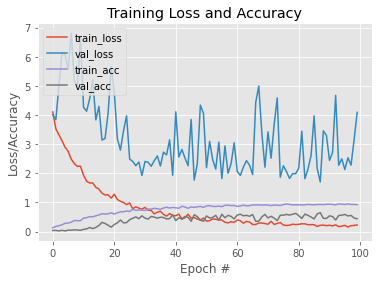

In [30]:
# График точности и потерь при обучении
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

### Save learning

In [29]:
model.save('deep_learningRMS.h5')

### Download 

In [31]:
from tensorflow.keras.models import load_model

In [43]:
model = load_model('deep_learning1.h5')

In [44]:
prediction = model.predict(testX)

In [45]:
test_loss, test_acc = model.evaluate(testX, testY)
print("Test loss: {}, Test Accuracy {}".format(test_loss, test_acc))

6/6 [==============================] - 3s 464ms/step - loss: 3.1949 - accuracy: 0.4492
Test loss: 3.1949234008789062, Test Accuracy 0.4491978585720062


In [46]:
prediction = model.predict([testX])

# Тестируем полученную модель

In [47]:
prediction[0][2]

1.1699228e-07

In [48]:
np.sum(prediction[0])

1.0000001

In [49]:
np.argmax(prediction[0])

12

In [50]:
print(prediction[0][np.argmax(prediction[0])]*100)

99.90591406822205


In [51]:
lb.inverse_transform(prediction)[0]

'Cucumbers__Healthy'

In [52]:
lb.inverse_transform(testY)[0]

'Cotton__Verticillium wilt'

# Вывод 

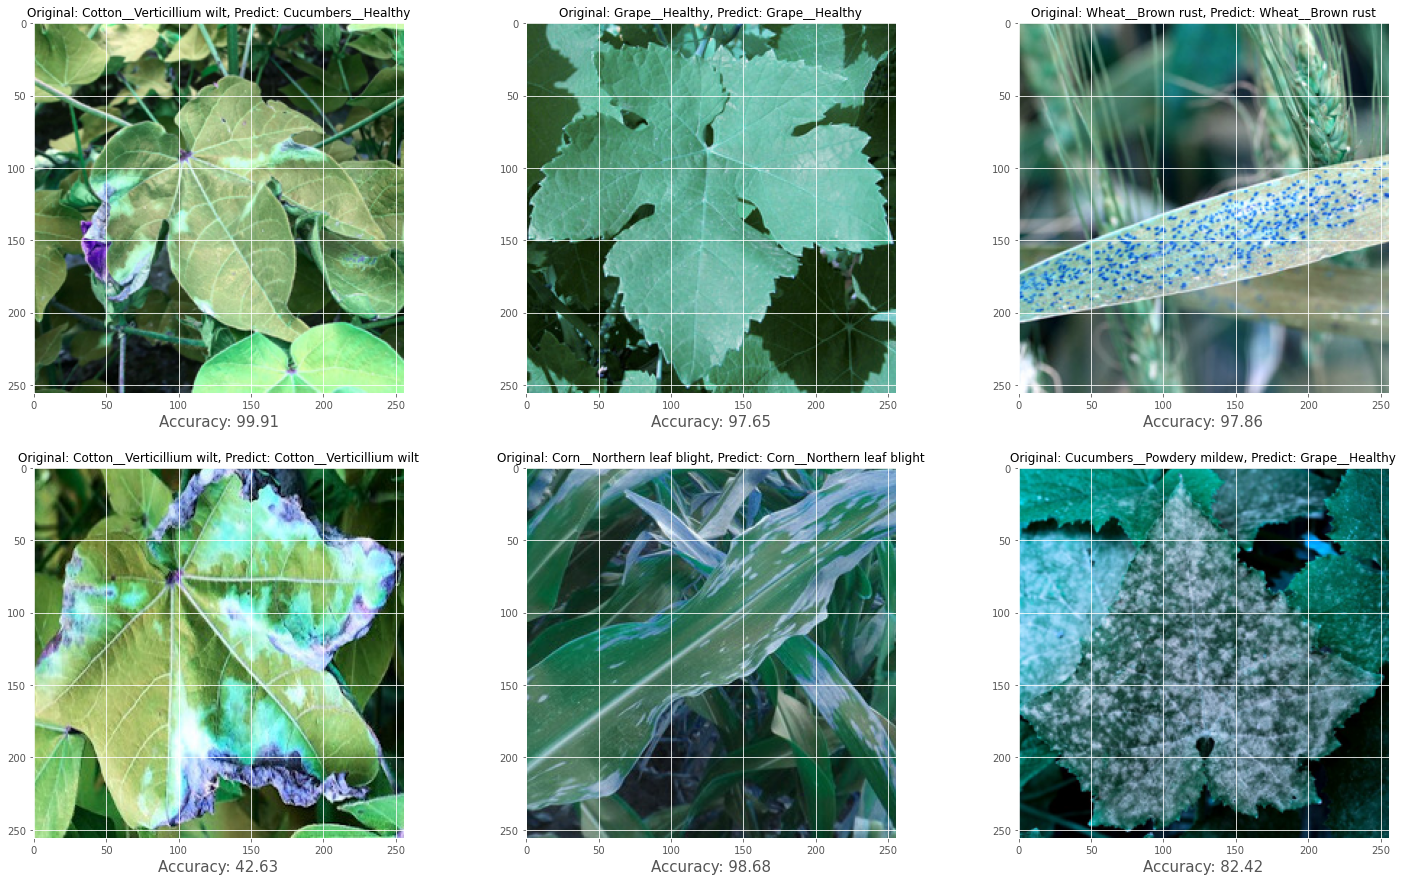

In [53]:
plt.figure(figsize=(25,15))
columns = 5
for i in range(0, 6):
    accuracy = round(prediction[i][np.argmax(prediction[i])]*100, 2)
    plt.subplot(2, 3, i + 1)
    plt.imshow(testX[i])
    plt.title("Original: {}, Predict: {}".format(lb.inverse_transform(testY)[i], lb.inverse_transform(prediction)[i],), size=12)
    plt.xlabel("Accuracy: {}".format(accuracy), size=15)

# Проверка для другого набора данных

In [54]:
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images("test_base")))

[INFO] loading images...


In [55]:
test_base = []
labels_test = []
#Перебираем изображения 
for imagePath in imagePaths:
    
    # загружаем изображение, предварительно обработать его и сохранив в списке данных
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image) #  преобразования изображения в массив, совместимый с Keras
    test_base.append(image)
    
    label = imagePath.split(os.path.sep)[-2]
    labels_test.append(label)

In [56]:
labels_test = np.array(labels_test)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

# Считывание меток
lb = LabelBinarizer()
labels_test = lb.fit_transform(labels_test)

[INFO] data matrix: 1436.16MB


In [57]:
test_base = np.array(test_base, dtype="float") / 255.0

In [58]:
prediction_test = model.predict([test_base])

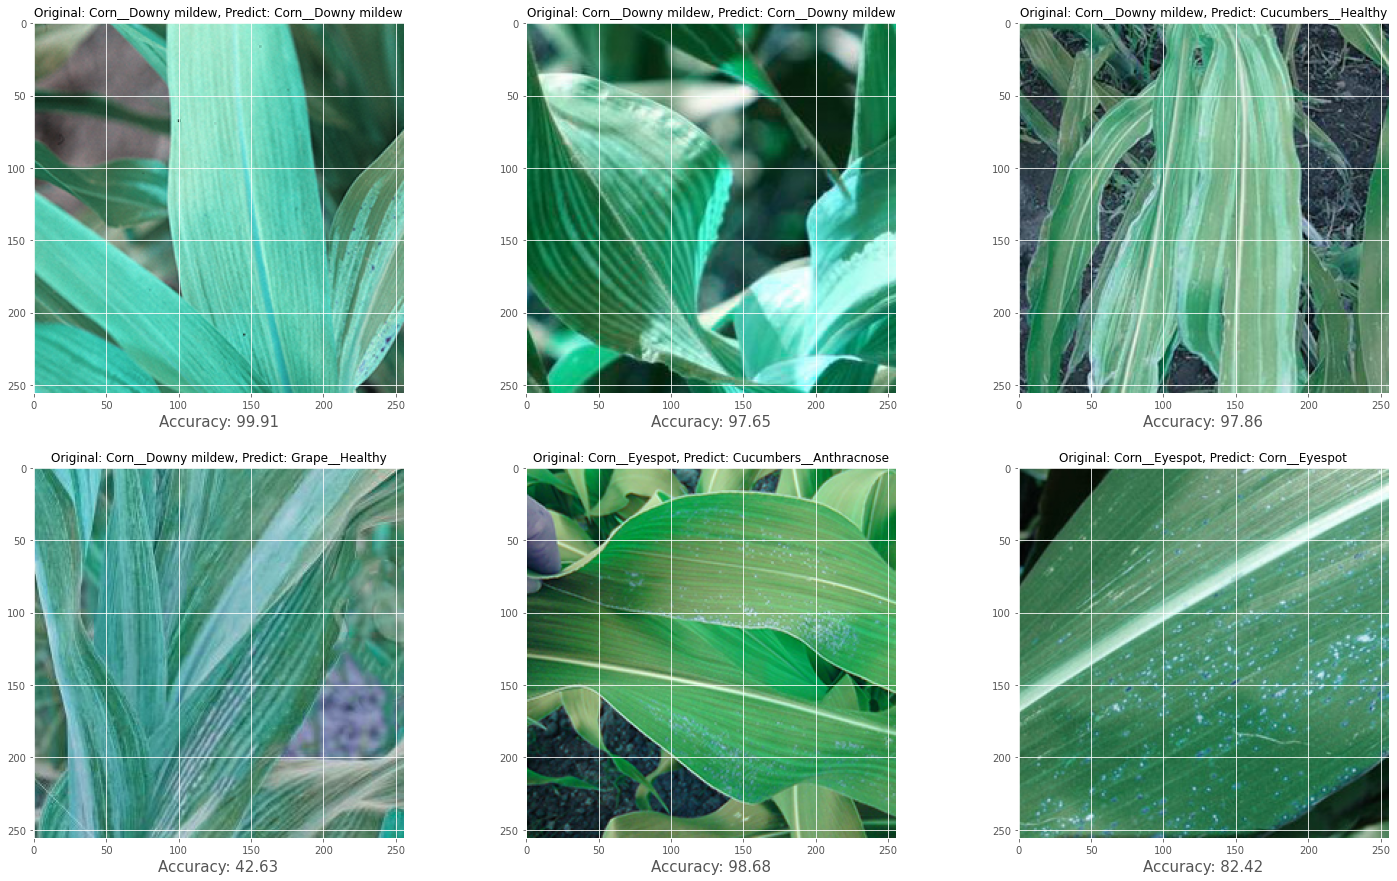

In [59]:
plt.figure(figsize=(25,15))
columns = 5
for i in range(0, 6):
    accuracy = round(prediction[i][np.argmax(prediction[i])]*100, 2)
    plt.subplot(2, 3, i + 1)
    plt.imshow(test_base[i])
    plt.title("Original: {}, Predict: {}".format(lb.inverse_transform(labels_test)[i], lb.inverse_transform(prediction_test)[i],), size=12)
    plt.xlabel("Accuracy: {}".format(accuracy), size=15)

# Разбиваем по DF

In [77]:
# Всё работает
pred = lb.inverse_transform(prediction)
pred = pd.DataFrame({'predict': pred})

In [78]:
truth = lb.inverse_transform(testY)
truth = pd.DataFrame({'truth': truth})

In [79]:
final = truth.join(pred)

In [80]:
final.to_csv('Prediction.csv', index=False)

In [81]:
final = pd.read_csv("Prediction.csv")
classes = final.truth.unique()
classes.sort()    

# Матрица ошибок

### На тестовой выборке

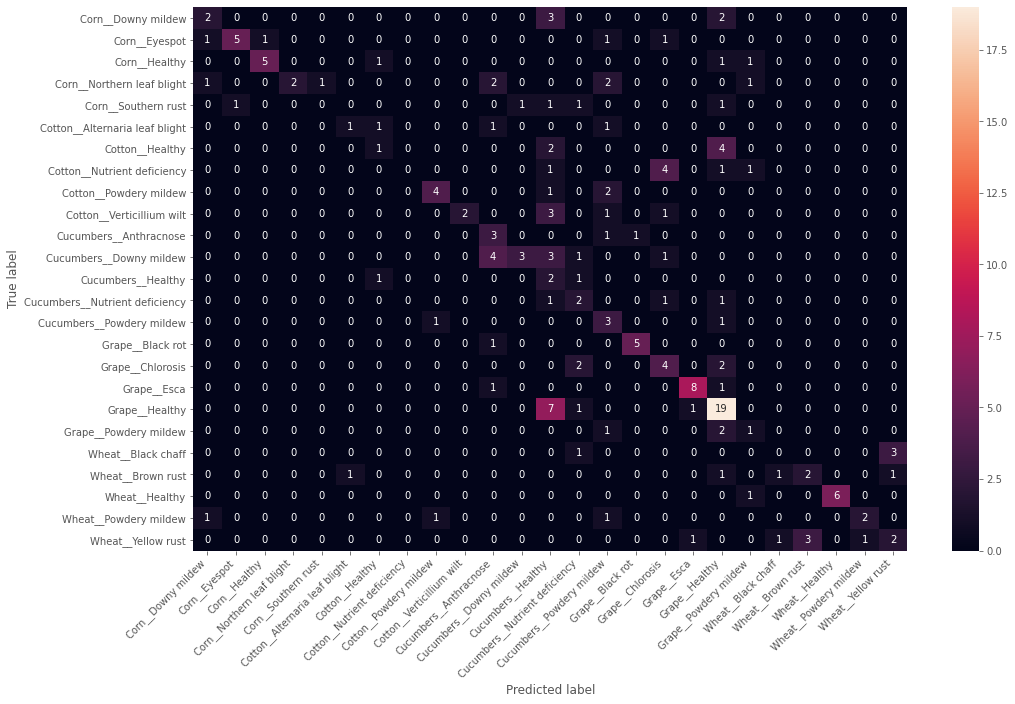

In [82]:
conf_matrix = confusion_matrix(lb.inverse_transform(testY), lb.inverse_transform(prediction))

df = pd.DataFrame(conf_matrix, index=classes, columns=classes, )

fig, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(df, annot = True, fmt = 'd', ax = ax)
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### На доп. выборке

In [62]:
pred = lb.inverse_transform(prediction_test)
pred = pd.DataFrame({'predict': pred})

In [63]:
truth = lb.inverse_transform(labels_test)
truth = pd.DataFrame({'truth': truth})

In [64]:
final = truth.join(pred)

In [65]:
final.to_csv('Prediction_test.csv', index=False)

In [66]:
final = pd.read_csv("Prediction_test.csv")
classes = final.truth.unique()
classes.sort() 

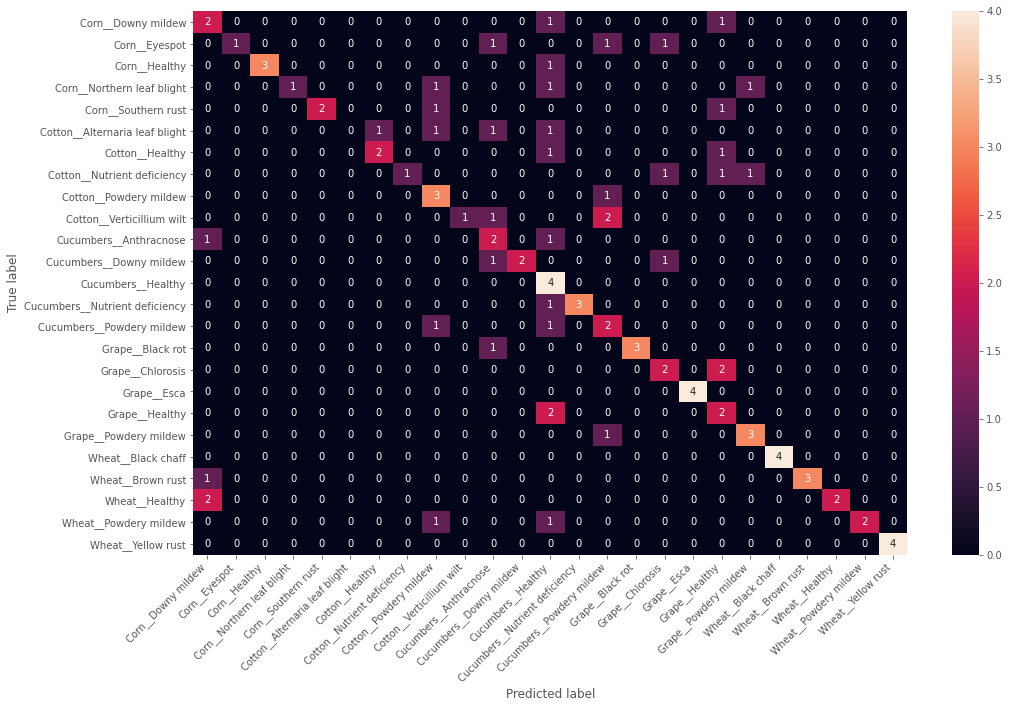

In [67]:
conf_matrix = confusion_matrix(lb.inverse_transform(labels_test), lb.inverse_transform(prediction_test))

df = pd.DataFrame(conf_matrix, index=classes, columns=classes, )

fig, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(df, annot = True, fmt = 'd', ax = ax)
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()